## Graph Attention
In this laboratory, we will learn how to implement a small neural network that implements graph attention, we wil be working over another network of citations. By the end of this lab you will be able to compare the accuracy of the standard GNN layer vs the one that implements attention.

![alt text](https://www.baeldung.com/wp-content/ql-cache/quicklatex.com-5984b032ad8f6224c7d4687270a915b0_l3.svg)

Once again let's begin by making sure the software dependencies are available in our machine:

In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


2.0.1+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 35.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Then load the required Libraries:

In [2]:
import torch
print(torch.__version__)

# Numpy for matrices
import numpy as np
np.random.seed(0)

# Visualization
import networkx as nx
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

2.0.1+cu118


We are working with the CiteSeer dataset, lets load the data and inspect a few of its properties.

In [3]:
from torch_geometric.datasets import Planetoid

# Import dataset from PyTorch Geometric
dataset = Planetoid(root=".", name='CiteSeer')

data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Processing...


Dataset: CiteSeer()
-------------------
Number of graphs: 1
Number of nodes: 3327
Number of features: 3703
Number of classes: 6

Graph:
------
Edges are directed: False
Graph has isolated nodes: True
Graph has loops: False


Done!


Before we proceed to the experiments, we remove the isolated nodes, we can not implement an attention operation on those nodes.

In [4]:
from torch_geometric.utils import remove_isolated_nodes
# We remove isolated nodes from the graph and print the number of isolated nodes
isolated = (remove_isolated_nodes(data['edge_index'])[2] == False).sum(dim=0).item()
print(f'Number of isolated nodes = {isolated}')

Number of isolated nodes = 48


Lets plot the dataset, observer there are some isolated clusters of nodes but no node is fully isolated.

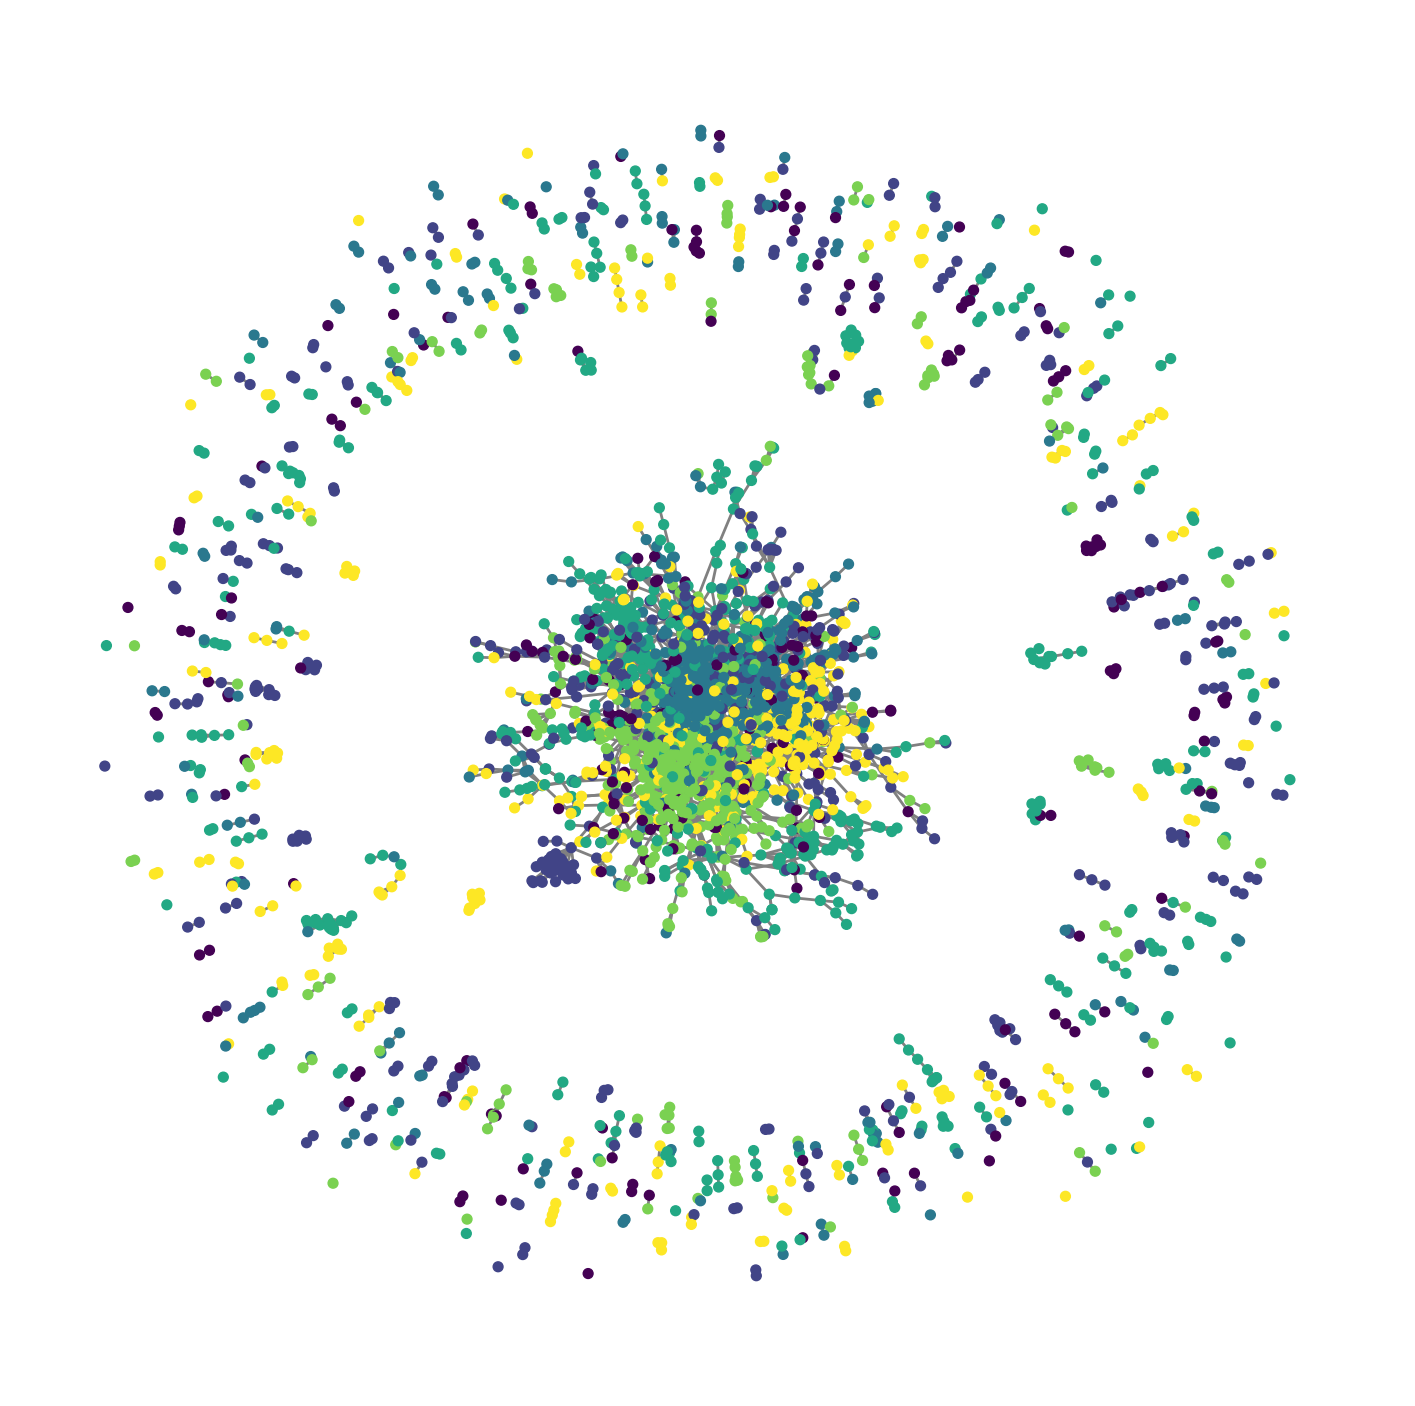

In [5]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(18,18))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=False,
                node_size=50,
                node_color=data.y,
                width=2,
                edge_color="grey"
                )
plt.show()

Lets implement a simple Graph attention neural network and a simple baseline using GCNConv.

In [6]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv


class GCN(torch.nn.Module):
  """Graph Convolutional Network"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.5, training=self.training)
    h = self.gcn1(h, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gcn2(h, edge_index)
    return h, F.log_softmax(h, dim=1)


class GAT(torch.nn.Module):
  """Graph Attention Network"""
  def __init__(self, dim_in, dim_h, dim_out, heads=8):
    super().__init__()
    self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
    self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.005,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.6, training=self.training)
    h = self.gat1(x, edge_index)
    h = F.relu(h)
    h = F.dropout(h, p=0.6, training=self.training)
    h = self.gat2(h, edge_index)
    return h, F.log_softmax(h, dim=1)



Finally we define our training and validation routines

In [7]:

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def train(model, data):
    """Train a GNN model and return the trained model."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = 200

    model.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

    return model

def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

First we Train the Standard GCN, we obtain about 60% accuracy.

In [10]:
%%time

# Create GCN model
gcn = GCN(dataset.num_features, 8, dataset.num_classes)
print(gcn)

# Train
train(gcn, data)

# Test
acc = test(gcn, data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(3703, 8)
  (gcn2): GCNConv(8, 6)
)
Epoch   0 | Train Loss: 1.802 | Train Acc:  20.00% | Val Loss: 1.78 | Val Acc: 20.20%
Epoch  10 | Train Loss: 0.896 | Train Acc:  65.83% | Val Loss: 1.36 | Val Acc: 50.80%
Epoch  20 | Train Loss: 0.474 | Train Acc:  87.50% | Val Loss: 1.32 | Val Acc: 54.00%
Epoch  30 | Train Loss: 0.324 | Train Acc:  95.83% | Val Loss: 1.34 | Val Acc: 54.20%
Epoch  40 | Train Loss: 0.245 | Train Acc:  95.83% | Val Loss: 1.47 | Val Acc: 56.40%
Epoch  50 | Train Loss: 0.179 | Train Acc:  95.00% | Val Loss: 1.54 | Val Acc: 53.20%
Epoch  60 | Train Loss: 0.191 | Train Acc:  95.00% | Val Loss: 1.54 | Val Acc: 53.80%
Epoch  70 | Train Loss: 0.164 | Train Acc:  95.83% | Val Loss: 1.42 | Val Acc: 58.20%
Epoch  80 | Train Loss: 0.122 | Train Acc:  96.67% | Val Loss: 1.57 | Val Acc: 57.20%
Epoch  90 | Train Loss: 0.162 | Train Acc:  95.00% | Val Loss: 1.61 | Val Acc: 56.60%
Epoch 100 | Train Loss: 0.200 | Train Acc:  93.33% | Val Loss: 1.60 | Val Acc: 57.

The we train the GNN with attention, we obatin about 65% accuracy

In [9]:
%%time

# Create GAT model
gat = GAT(dataset.num_features, 8, dataset.num_classes)
print(gat)

# Train
train(gat, data)

# Test
acc = test(gat, data)
print(f'\nGAT test accuracy: {acc*100:.2f}%\n')

GAT(
  (gat1): GATv2Conv(3703, 8, heads=8)
  (gat2): GATv2Conv(64, 6, heads=1)
)
Epoch   0 | Train Loss: 1.790 | Train Acc:  25.00% | Val Loss: 1.81 | Val Acc: 16.60%
Epoch  10 | Train Loss: 0.204 | Train Acc:  96.67% | Val Loss: 1.12 | Val Acc: 63.00%
Epoch  20 | Train Loss: 0.049 | Train Acc:  99.17% | Val Loss: 1.25 | Val Acc: 60.80%
Epoch  30 | Train Loss: 0.023 | Train Acc: 100.00% | Val Loss: 1.23 | Val Acc: 64.40%
Epoch  40 | Train Loss: 0.008 | Train Acc: 100.00% | Val Loss: 1.34 | Val Acc: 63.40%
Epoch  50 | Train Loss: 0.007 | Train Acc: 100.00% | Val Loss: 1.28 | Val Acc: 63.40%
Epoch  60 | Train Loss: 0.008 | Train Acc: 100.00% | Val Loss: 1.25 | Val Acc: 62.80%
Epoch  70 | Train Loss: 0.019 | Train Acc: 100.00% | Val Loss: 1.31 | Val Acc: 62.00%
Epoch  80 | Train Loss: 0.011 | Train Acc: 100.00% | Val Loss: 1.24 | Val Acc: 62.40%
Epoch  90 | Train Loss: 0.011 | Train Acc: 100.00% | Val Loss: 1.18 | Val Acc: 63.80%
Epoch 100 | Train Loss: 0.012 | Train Acc: 100.00% | Val Lo

| Method | Cora | Citeseer | Pubmed |
| :--- | :--- | :--- | :--- |
| MLP | $55.1 \%$ | $46.5 \%$ | $71.4 \%$ |
| ManiReg (Belkin et al., 2006) | $59.5 \%$ | $60.1 \%$ | $70.7 \%$ |
| SemiEmb (Weston et al., 2012) | $59.0 \%$ | $59.6 \%$ | $71.7 \%$ |
| LP (Zhu et al., 2003) | $68.0 \%$ | $45.3 \%$ | $63.0 \%$ |
| DeepWalk (Perozzi et al., 2014) | $67.2 \%$ | $43.2 \%$ | $65.3 \%$ |
| ICA (Lu & Getoor, 2003) | $75.1 \%$ | $69.1 \%$ | $73.9 \%$ |
| Planetoid (Yang et al., 2016) | $75.7 \%$ | $64.7 \%$ | $77.2 \%$ |
| Chebyshev (Defferrard et al., 2016) | $81.2 \%$ | $69.8 \%$ | $74.4 \%$ |
| GCN (Kipf & Welling, 2017) | $81.5 \%$ | $70.3 \%$ | $\mathbf{7 9 . 0 \%}$ |
| MoNet (Monti et al., 2016) | $81.7 \pm 0.5 \%$ | - | $78.8 \pm 0.3 \%$ |
| GCN-64* | $81.4 \pm 0.5 \%$ | $70.9 \pm 0.5 \%$ | $\mathbf{7 9 . 0} \pm 0.3 \%$ |
| GAT (ours) | $\mathbf{8 3 } \pm 0.7 \%$ | $\mathbf{7 2 . 5} \pm 0.7 \%$ | $\mathbf{7 9 . 0} \pm 0.3 \%$ |

Some sources to learn more about attention and transformers:
* [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)
* [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf)
* [Graph Attention Networks](https://arxiv.org/pdf/1710.10903.pdf)

If you are interested to learn more about transformers [Which uses attention], read this [survey paper](https://arxiv.org/abs/2101.01169) and checkout these applications:

- Language: [BERT](https://arxiv.org/abs/1810.04805), [GPT-3](https://arxiv.org/abs/2005.14165), [DeBERTa](https://arxiv.org/abs/2006.03654)
- Images: [IT](https://arxiv.org/abs/1802.05751), [ViT](https://ai.googleblog.com/2020/12/transformers-for-image-recognition-at.html), [IPT](https://arxiv.org/abs/2012.00364), [BoTNet](https://arxiv.org/abs/2101.11605), [PVT](https://arxiv.org/abs/2102.12122), [iGPT](https://openai.com/blog/image-gpt/), [DETR](https://alcinos.github.io/detr_page/), [SETR](https://arxiv.org/abs/2012.15840)
- Video: [VTN](https://arxiv.org/abs/2102.00719), [TimeSformer](https://arxiv.org/abs/2102.05095)
- Point Clouds: [CT](https://arxiv.org/abs/2007.11679), [PT](https://arxiv.org/abs/2012.09164), [PCT](https://arxiv.org/abs/2012.09688)

I hope these projects gave you a hands-on experience with deep learning. Now is definitely an [exciting time for AI](https://spectrum.ieee.org/the-institute/ieee-member-news/stop-calling-everything-ai-machinelearning-pioneer-says.amp.html). We barely scratched the surface but the posibilities are wide open.